In [ ]:
#| default_exp models.patchtst

# PatchTST

The PatchTST model is an efficient Transformer-based model for multivariate time series forecasting.

It is based on two key components:
- segmentation of time series into windows (patches) which are served as input tokens to Transformer
- channel-independence. where each channel contains a single univariate time series.

**References**<br>
- [Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). "A Time Series is Worth 64 Words: Long-term Forecasting with Transformers"](https://arxiv.org/pdf/2211.14730.pdf)<br>

![Figure 1. PatchTST.](imgs_models/patchtst.png)

In [ ]:
#| export
import math
import numpy as np
from typing import Optional #, Any, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.common._modules import RevIN

from neuralforecast.losses.pytorch import MAE

c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-28 16:04:37,055	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-28 16:04:37,164	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

## 1. Backbone

### Auxiliary Functions

In [ ]:
#| export
class Transpose(nn.Module):
    """
    Transpose
    """
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)

def get_activation_fn(activation):
    if callable(activation): return activation()
    elif activation.lower() == "relu": return nn.ReLU()
    elif activation.lower() == "gelu": return nn.GELU()
    raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable') 

### Positional Encoding

In [ ]:
#| export
def PositionalEncoding(q_len, hidden_size, normalize=True):
    pe = torch.zeros(q_len, hidden_size)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, hidden_size, 2) * -(math.log(10000.0) / hidden_size))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe

SinCosPosEncoding = PositionalEncoding

def Coord2dPosEncoding(q_len, hidden_size, exponential=False, normalize=True, eps=1e-3):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, hidden_size).reshape(1, -1) ** x) - 1
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def Coord1dPosEncoding(q_len, exponential=False, normalize=True):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def positional_encoding(pe, learn_pe, q_len, hidden_size):
    # Positional encoding
    if pe == None:
        W_pos = torch.empty((q_len, hidden_size)) # pe = None and learn_pe = False can be used to measure impact of pe
        nn.init.uniform_(W_pos, -0.02, 0.02)
        learn_pe = False
    elif pe == 'zero':
        W_pos = torch.empty((q_len, 1))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'zeros':
        W_pos = torch.empty((q_len, hidden_size))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'normal' or pe == 'gauss':
        W_pos = torch.zeros((q_len, 1))
        torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
    elif pe == 'uniform':
        W_pos = torch.zeros((q_len, 1))
        nn.init.uniform_(W_pos, a=0.0, b=0.1)
    elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
    elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
    elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, hidden_size, exponential=False, normalize=True)
    elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, hidden_size, exponential=True, normalize=True)
    elif pe == 'sincos': W_pos = PositionalEncoding(q_len, hidden_size, normalize=True)
    else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
        'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
    return nn.Parameter(W_pos, requires_grad=learn_pe)

### Encoder

In [ ]:
#| export
class PatchTST_backbone(nn.Module):
    """
    PatchTST_backbone
    """      
    def __init__(self, c_in:int, c_out:int, input_size:int, h:int, patch_len:int, stride:int, max_seq_len:Optional[int]=1024, 
                 n_layers:int=3, hidden_size=128, n_heads=16, d_k:Optional[int]=None, d_v:Optional[int]=None,
                 linear_hidden_size:int=256, norm:str='BatchNorm', attn_dropout:float=0., dropout:float=0., act:str="gelu", key_padding_mask:str='auto',
                 padding_var:Optional[int]=None, attn_mask:Optional[torch.Tensor]=None, res_attention:bool=True, pre_norm:bool=False, store_attn:bool=False,
                 pe:str='zeros', learn_pe:bool=True, fc_dropout:float=0., head_dropout = 0, padding_patch = None,
                 pretrain_head:bool=False, head_type = 'flatten', individual = False, revin = True, affine = True, subtract_last = False):
        
        super().__init__()

        # RevIn
        self.revin = revin
        if self.revin: self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)

        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((input_size - patch_len)/stride + 1)
        if padding_patch == 'end': # can be modified to general case
            self.padding_patch_layer = nn.ReplicationPad1d((0, stride)) 
            patch_num += 1

        # Backbone 
        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, hidden_size=hidden_size, n_heads=n_heads, d_k=d_k, d_v=d_v, linear_hidden_size=linear_hidden_size,
                                attn_dropout=attn_dropout, dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                pe=pe, learn_pe=learn_pe)

        # Head
        self.head_nf = hidden_size * patch_num
        self.n_vars = c_in
        self.c_out = c_out
        self.pretrain_head = pretrain_head
        self.head_type = head_type
        self.individual = individual

        if self.pretrain_head: 
            self.head = self.create_pretrain_head(self.head_nf, c_in, fc_dropout) # custom head passed as a partial func with all its kwargs
        elif head_type == 'flatten': 
            self.head = Flatten_Head(self.individual, self.n_vars, self.head_nf, h, c_out, head_dropout=head_dropout)

    def forward(self, z):                                                                   # z: [bs x nvars x seq_len]
        # norm
        if self.revin: 
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'norm')
            z = z.permute(0,2,1)

        # do patching
        if self.padding_patch == 'end':
            z = self.padding_patch_layer(z)
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                   # z: [bs x nvars x patch_num x patch_len]
        z = z.permute(0,1,3,2)                                                              # z: [bs x nvars x patch_len x patch_num]

        # model
        z = self.backbone(z)                                                                # z: [bs x nvars x hidden_size x patch_num]
        z = self.head(z)                                                                    # z: [bs x nvars x h] 

        # denorm
        if self.revin:
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'denorm')
            z = z.permute(0,2,1)
        return z
    
    def create_pretrain_head(self, head_nf, vars, dropout):
        return nn.Sequential(nn.Dropout(dropout),
                    nn.Conv1d(head_nf, vars, 1)
                    )


class Flatten_Head(nn.Module):
    """
    Flatten_Head
    """        
    def __init__(self, individual, n_vars, nf, h, c_out, head_dropout=0):
        super().__init__()
        
        self.individual = individual
        self.n_vars = n_vars
        self.c_out = c_out
        
        if self.individual:
            self.linears = nn.ModuleList()
            self.dropouts = nn.ModuleList()
            self.flattens = nn.ModuleList()
            for i in range(self.n_vars):
                self.flattens.append(nn.Flatten(start_dim=-2))
                self.linears.append(nn.Linear(nf, h*c_out))
                self.dropouts.append(nn.Dropout(head_dropout))
        else:
            self.flatten = nn.Flatten(start_dim=-2)
            self.linear = nn.Linear(nf, h*c_out)
            self.dropout = nn.Dropout(head_dropout)
            
    def forward(self, x):                                 # x: [bs x nvars x hidden_size x patch_num]
        if self.individual:
            x_out = []
            for i in range(self.n_vars):
                z = self.flattens[i](x[:,i,:,:])          # z: [bs x hidden_size * patch_num]
                z = self.linears[i](z)                    # z: [bs x h]
                z = self.dropouts[i](z)
                x_out.append(z)
            x = torch.stack(x_out, dim=1)                 # x: [bs x nvars x h]
        else:
            x = self.flatten(x)
            x = self.linear(x)
            x = self.dropout(x)
        return x


class TSTiEncoder(nn.Module):  #i means channel-independent
    """
    TSTiEncoder
    """      
    def __init__(self, c_in, patch_num, patch_len, max_seq_len=1024,
                 n_layers=3, hidden_size=128, n_heads=16, d_k=None, d_v=None,
                 linear_hidden_size=256, norm='BatchNorm', attn_dropout=0., dropout=0., act="gelu", store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 pe='zeros', learn_pe=True):
        
        
        super().__init__()
        
        self.patch_num = patch_num
        self.patch_len = patch_len
        
        # Input encoding
        q_len = patch_num
        self.W_P = nn.Linear(patch_len, hidden_size)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        self.W_pos = positional_encoding(pe, learn_pe, q_len, hidden_size)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = TSTEncoder(q_len, hidden_size, n_heads, d_k=d_k, d_v=d_v, linear_hidden_size=linear_hidden_size, norm=norm, attn_dropout=attn_dropout, dropout=dropout,
                                   pre_norm=pre_norm, activation=act, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)
        
    def forward(self, x) -> torch.Tensor:                                        # x: [bs x nvars x patch_len x patch_num]
        
        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x hidden_size]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # u: [bs * nvars x patch_num x hidden_size]
        u = self.dropout(u + self.W_pos)                                         # u: [bs * nvars x patch_num x hidden_size]

        # Encoder
        z = self.encoder(u)                                                      # z: [bs * nvars x patch_num x hidden_size]
        z = torch.reshape(z, (-1,n_vars,z.shape[-2],z.shape[-1]))                # z: [bs x nvars x patch_num x hidden_size]
        z = z.permute(0,1,3,2)                                                   # z: [bs x nvars x hidden_size x patch_num]
        
        return z    
            

class TSTEncoder(nn.Module):
    """
    TSTEncoder
    """     
    def __init__(self, q_len, hidden_size, n_heads, d_k=None, d_v=None, linear_hidden_size=None, 
                        norm='BatchNorm', attn_dropout=0., dropout=0., activation='gelu',
                        res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        super().__init__()

        self.layers = nn.ModuleList([TSTEncoderLayer(q_len, hidden_size, n_heads=n_heads, d_k=d_k, d_v=d_v, linear_hidden_size=linear_hidden_size, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      activation=activation, res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src:torch.Tensor, key_padding_mask:Optional[torch.Tensor]=None, attn_mask:Optional[torch.Tensor]=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output


class TSTEncoderLayer(nn.Module):
    """
    TSTEncoderLayer
    """      
    def __init__(self, q_len, hidden_size, n_heads, d_k=None, d_v=None, linear_hidden_size=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, activation="gelu", res_attention=False, pre_norm=False):
        super().__init__()
        assert not hidden_size%n_heads, f"hidden_size ({hidden_size}) must be divisible by n_heads ({n_heads})"
        d_k = hidden_size // n_heads if d_k is None else d_k
        d_v = hidden_size // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(hidden_size, n_heads, d_k, d_v, attn_dropout=attn_dropout,
                                             proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(hidden_size), Transpose(1,2))
        else:
            self.norm_attn = nn.LayerNorm(hidden_size)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(hidden_size, linear_hidden_size, bias=bias),
                                get_activation_fn(activation),
                                nn.Dropout(dropout),
                                nn.Linear(linear_hidden_size, hidden_size, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(hidden_size), Transpose(1,2))
        else:
            self.norm_ffn = nn.LayerNorm(hidden_size)

        self.pre_norm = pre_norm
        self.store_attn = store_attn

    def forward(self, src:torch.Tensor, prev:Optional[torch.Tensor]=None,
                key_padding_mask:Optional[torch.Tensor]=None,
                attn_mask:Optional[torch.Tensor]=None): # -> Tuple[torch.Tensor, Any]:

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev,
                                                key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src


class _MultiheadAttention(nn.Module):
    """
    _MultiheadAttention
    """       
    def __init__(self, hidden_size, n_heads, d_k=None, d_v=None,
                 res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True, lsa=False):
        """
        Multi Head Attention Layer
        Input shape:
            Q:       [batch_size (bs) x max_q_len x hidden_size]
            K, V:    [batch_size (bs) x q_len x hidden_size]
            mask:    [q_len x q_len]
        """
        super().__init__()
        d_k = hidden_size // n_heads if d_k is None else d_k
        d_v = hidden_size // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(hidden_size, d_k * n_heads, bias=qkv_bias)
        self.W_K = nn.Linear(hidden_size, d_k * n_heads, bias=qkv_bias)
        self.W_V = nn.Linear(hidden_size, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(hidden_size, n_heads, attn_dropout=attn_dropout,
                                                   res_attention=self.res_attention, lsa=lsa)

        # Poject output
        self.to_out = nn.Sequential(nn.Linear(n_heads * d_v, hidden_size), nn.Dropout(proj_dropout))

    def forward(self, Q:torch.Tensor, K:Optional[torch.Tensor]=None, V:Optional[torch.Tensor]=None, prev:Optional[torch.Tensor]=None,
                key_padding_mask:Optional[torch.Tensor]=None, attn_mask:Optional[torch.Tensor]=None):

        bs = Q.size(0)
        if K is None: K = Q
        if V is None: V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s,
                                                    prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights


class _ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot-Product Attention module (Attention is all you need by Vaswani et al., 2017) with optional residual attention from previous layer
    (Realformer: Transformer likes residual attention by He et al, 2020) and locality self sttention (Vision Transformer for Small-Size Datasets
    by Lee et al, 2021)
    """

    def __init__(self, hidden_size, n_heads, attn_dropout=0., res_attention=False, lsa=False):
        super().__init__()
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = hidden_size // n_heads
        self.scale = nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(self, q:torch.Tensor, k:torch.Tensor, v:torch.Tensor,
                prev:Optional[torch.Tensor]=None, key_padding_mask:Optional[torch.Tensor]=None,
                attn_mask:Optional[torch.Tensor]=None):
        '''
        Input shape:
            q               : [bs x n_heads x max_q_len x d_k]
            k               : [bs x n_heads x d_k x seq_len]
            v               : [bs x n_heads x seq_len x d_v]
            prev            : [bs x n_heads x q_len x seq_len]
            key_padding_mask: [bs x seq_len]
            attn_mask       : [1 x seq_len x seq_len]
        Output shape:
            output:  [bs x n_heads x q_len x d_v]
            attn   : [bs x n_heads x q_len x seq_len]
            scores : [bs x n_heads x q_len x seq_len]
        '''

        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = torch.matmul(q, k) * self.scale      # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None: attn_scores = attn_scores + prev

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if key_padding_mask is not None:                              # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf)

        # normalize the attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)                 # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)                        # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

## 2. Model

In [ ]:
#| export
class PatchTST(BaseWindows):
    """ PatchTST

    The PatchTST model is an efficient Transformer-based model for multivariate time series forecasting.

    It is based on two key components:
    - segmentation of time series into windows (patches) which are served as input tokens to Transformer
    - channel-independence, where each channel contains a single univariate time series.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `encoder_layers`: int, number of layers for encoder.<br>
    `n_heads`: int=16, number of multi-head's attention.<br>
    `hidden_size`: int=128, units of embeddings and encoders.<br>
    `linear_hidden_size`: int=256, units of linear layer.<br>
    `dropout`: float=0.1, dropout rate for residual connection.<br>
    `fc_dropout`: float=0.1, dropout rate for linear layer.<br>
    `head_dropout`: float=0.1, dropout rate for Flatten head layer.<br>
    `attn_dropout`: float=0.1, dropout rate for attention layer.<br>
    `patch_len`: int=32, length of patch. Note: patch_len = min(patch_len, input_size + stride).<br>
    `stride`: int=16, stride of patch.<br>
    `revin`: bool=True, bool to use RevIn.<br>
    `revin_affine`: bool=False, bool to use affine in RevIn.<br>
    `revin_substract_last`: bool=False, bool to use substract last in RevIn.<br>
    `activation`: str='ReLU', activation from ['gelu','relu'].<br>
    `res_attention`: bool=False, bool to use residual attention.<br>
    `batch_normalization`: bool=False, bool to use batch normalization.<br>
    `learn_pos_embedding`: bool=True, bool to learn positional embedding.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=1024, number of windows to sample in each inference batch.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
    `dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References:**<br>
    -[Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). "A Time Series is Worth 64 Words: Long-term Forecasting with Transformers"](https://arxiv.org/pdf/2211.14730.pdf)
    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False

    def __init__(self,
                 h,
                 input_size,
                 stat_exog_list = None,
                 hist_exog_list = None,
                 futr_exog_list = None,
                 exclude_insample_y = False,
                 encoder_layers: int = 3,
                 n_heads: int = 16,
                 hidden_size: int = 128,
                 linear_hidden_size: int = 256,
                 dropout: float = 0.2,
                 fc_dropout: float = 0.2,
                 head_dropout: float = 0.0,
                 attn_dropout: float = 0.,
                 patch_len: int = 16,
                 stride: int = 8,
                 revin: bool = True,
                 revin_affine: bool = False,
                 revin_subtract_last: bool = True,
                 activation: str = "gelu",
                 res_attention: bool = True, 
                 batch_normalization: bool = False,
                 learn_pos_embed: bool = True,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 5000,
                 learning_rate: float = 1e-4,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size = 1024,
                 inference_windows_batch_size: int = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,
                 dataloader_kwargs = None,
                 **trainer_kwargs):
        super(PatchTST, self).__init__(h=h,
                                       input_size=input_size,
                                       hist_exog_list=hist_exog_list,
                                       stat_exog_list=stat_exog_list,
                                       futr_exog_list = futr_exog_list,
                                       exclude_insample_y = exclude_insample_y,
                                       loss=loss,
                                       valid_loss=valid_loss,
                                       max_steps=max_steps,
                                       learning_rate=learning_rate,
                                       num_lr_decays=num_lr_decays,
                                       early_stop_patience_steps=early_stop_patience_steps,
                                       val_check_steps=val_check_steps,
                                       batch_size=batch_size,
                                       valid_batch_size=valid_batch_size,
                                       windows_batch_size=windows_batch_size,
                                       inference_windows_batch_size=inference_windows_batch_size,
                                       start_padding_enabled=start_padding_enabled,
                                       step_size=step_size,
                                       scaler_type=scaler_type,
                                       drop_last_loader=drop_last_loader,
                                       random_seed=random_seed,
                                       optimizer=optimizer,
                                       optimizer_kwargs=optimizer_kwargs,
                                       lr_scheduler=lr_scheduler,
                                       lr_scheduler_kwargs=lr_scheduler_kwargs,
                                       dataloader_kwargs=dataloader_kwargs,
                                       **trainer_kwargs) 

        # Enforce correct patch_len, regardless of user input
        patch_len = min(input_size + stride, patch_len)

        c_out = self.loss.outputsize_multiplier

        # Fixed hyperparameters
        c_in = 1                  # Always univariate
        padding_patch='end'       # Padding at the end
        pretrain_head = False     # No pretrained head
        norm = 'BatchNorm'        # Use BatchNorm (if batch_normalization is True)
        pe = 'zeros'              # Initial zeros for positional encoding 
        d_k = None                # Key dimension
        d_v = None                # Value dimension
        store_attn = False        # Store attention weights
        head_type = 'flatten'     # Head type
        individual = False        # Separate heads for each time series
        max_seq_len = 1024        # Not used
        key_padding_mask = 'auto' # Not used
        padding_var = None        # Not used
        attn_mask = None          # Not used

        self.model = PatchTST_backbone(c_in=c_in, c_out=c_out, input_size=input_size, h=h, patch_len=patch_len, stride=stride, 
                                max_seq_len=max_seq_len, n_layers=encoder_layers, hidden_size=hidden_size,
                                n_heads=n_heads, d_k=d_k, d_v=d_v, linear_hidden_size=linear_hidden_size, norm=norm, attn_dropout=attn_dropout,
                                dropout=dropout, act=activation, key_padding_mask=key_padding_mask, padding_var=padding_var, 
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=batch_normalization, store_attn=store_attn,
                                pe=pe, learn_pe=learn_pos_embed, fc_dropout=fc_dropout, head_dropout=head_dropout, padding_patch = padding_patch,
                                pretrain_head=pretrain_head, head_type=head_type, individual=individual, revin=revin, affine=revin_affine,
                                subtract_last=revin_subtract_last)
    
    
    def forward(self, windows_batch):  # x: [batch, input_size]

        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        #insample_mask = windows_batch['insample_mask']
        #hist_exog     = windows_batch['hist_exog']
        #stat_exog     = windows_batch['stat_exog']
        #futr_exog     = windows_batch['futr_exog']

        # Add dimension for channel
        x = insample_y.unsqueeze(-1) # [Ws,L,1]

        x = x.permute(0,2,1)    # x: [Batch, 1, input_size]
        x = self.model(x)
        x = x.reshape(x.shape[0], self.h, -1) # x: [Batch, h, c_out]

        # Domain map
        forecast = self.loss.domain_map(x)
        
        return forecast

In [ ]:
show_doc(PatchTST)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/patchtst.py#L788){target="_blank" style="float:right; font-size:smaller"}

### PatchTST

>      PatchTST (h, input_size, stat_exog_list=None, hist_exog_list=None,
>                futr_exog_list=None, exclude_insample_y=False,
>                encoder_layers:int=3, n_heads:int=16, hidden_size:int=128,
>                linear_hidden_size:int=256, dropout:float=0.2,
>                fc_dropout:float=0.2, head_dropout:float=0.0,
>                attn_dropout:float=0.0, patch_len:int=16, stride:int=8,
>                revin:bool=True, revin_affine:bool=False,
>                revin_subtract_last:bool=True, activation:str='gelu',
>                res_attention:bool=True, batch_normalization:bool=False,
>                learn_pos_embed:bool=True, loss=MAE(), valid_loss=None,
>                max_steps:int=5000, learning_rate:float=0.0001,
>                num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>                val_check_steps:int=100, batch_size:int=32,
>                valid_batch_size:Optional[int]=None, windows_batch_size=1024,
>                inference_windows_batch_size:int=1024,
>                start_padding_enabled=False, step_size:int=1,
>                scaler_type:str='identity', random_seed:int=1,
>                drop_last_loader:bool=False, optimizer=None,
>                optimizer_kwargs=None, lr_scheduler=None,
>                lr_scheduler_kwargs=None, dataloader_kwargs=None,
>                **trainer_kwargs)

*PatchTST

The PatchTST model is an efficient Transformer-based model for multivariate time series forecasting.

It is based on two key components:
- segmentation of time series into windows (patches) which are served as input tokens to Transformer
- channel-independence, where each channel contains a single univariate time series.

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`encoder_layers`: int, number of layers for encoder.<br>
`n_heads`: int=16, number of multi-head's attention.<br>
`hidden_size`: int=128, units of embeddings and encoders.<br>
`linear_hidden_size`: int=256, units of linear layer.<br>
`dropout`: float=0.1, dropout rate for residual connection.<br>
`fc_dropout`: float=0.1, dropout rate for linear layer.<br>
`head_dropout`: float=0.1, dropout rate for Flatten head layer.<br>
`attn_dropout`: float=0.1, dropout rate for attention layer.<br>
`patch_len`: int=32, length of patch. Note: patch_len = min(patch_len, input_size + stride).<br>
`stride`: int=16, stride of patch.<br>
`revin`: bool=True, bool to use RevIn.<br>
`revin_affine`: bool=False, bool to use affine in RevIn.<br>
`revin_substract_last`: bool=False, bool to use substract last in RevIn.<br>
`activation`: str='ReLU', activation from ['gelu','relu'].<br>
`res_attention`: bool=False, bool to use residual attention.<br>
`batch_normalization`: bool=False, bool to use batch normalization.<br>
`learn_pos_embedding`: bool=True, bool to learn positional embedding.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=1024, number of windows to sample in each inference batch.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>    
`dataloader_kwargs`: dict, optional, list of parameters passed into the PyTorch Lightning dataloader by the `TimeSeriesDataLoader`. <br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References:**<br>
-[Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). "A Time Series is Worth 64 Words: Long-term Forecasting with Transformers"](https://arxiv.org/pdf/2211.14730.pdf)*

In [ ]:
show_doc(PatchTST.fit, name='PatchTST.fit')

---

### PatchTST.fit

>      PatchTST.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                    distributed_config=None)

*Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>*

In [ ]:
show_doc(PatchTST.predict, name='PatchTST.predict')

---

### PatchTST.predict

>      PatchTST.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                        **data_module_kwargs)

*Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).*

## Usage example

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 32.2 K | train
-----------------------------------------------------------
32.2 K    Trainable params
8         Non-trainable params
32.3 K    Total

Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 25.75it/s, v_num=9332, train_loss_step=5.48e+3, train_loss_epoch=5.48e+3, valid_loss=13.70]


c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\ospra\miniconda3\envs\neuralforecast\lib\site-packages\utilsforecast\processing.py:438: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.59it/s]


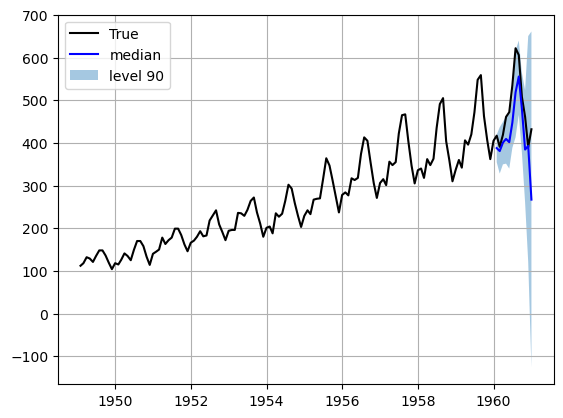

In [ ]:
#| eval: false
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic, augment_calendar_df

AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = PatchTST(h=12,
                 input_size=104,
                 patch_len=24,
                 stride=24,
                 revin=False,
                 hidden_size=16,
                 n_heads=4,
                 scaler_type='robust',
                 loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                 #loss=MAE(),
                 learning_rate=1e-3,
                 max_steps=500,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = nf.predict(futr_df=Y_test_df)

Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

if model.loss.is_distribution_output:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['PatchTST-median'], c='blue', label='median')
    plt.fill_between(x=plot_df['ds'][-12:], 
                    y1=plot_df['PatchTST-lo-90'][-12:].values, 
                    y2=plot_df['PatchTST-hi-90'][-12:].values,
                    alpha=0.4, label='level 90')
    plt.grid()
    plt.legend()
    plt.plot()
else:
    plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
    plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
    plt.plot(plot_df['ds'], plot_df['PatchTST'], c='blue', label='Forecast')
    plt.legend()
    plt.grid()